+ 通过前面实现的DDP我们可以知道，数据并行之所以能够加速训练，是因为它能够提高每一个epoch训练的batch_size，并且使用ring allreduce缓解了传统PS-worker模式下的通信问题，但是，DDP会在每张卡上都保留一个模型的副本，仍然不能解决当模型过大使得一张卡放不下的问题，因此提出模型并行，将一份大模型按照不同的layer切分(shard)到不同的卡上，实现很简单，加载huggingface上面的模型时，会自动按照GPUs > CPU > Disk的优先级进行划分

In [15]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
model = LlamaForCausalLM.from_pretrained("decanlp/llama-7b-hf", device_map="auto", load_in_8bit=True)

# 受限于学校局域网没有代理无法连接，大概效果就是会将模型参数平分到每张GPU上，即使模型能够放在一张GPU上也会分到多张GPU上
print(model.hf_device_map)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

+ 下面实现一个ResNet50的模型分割

In [3]:
import torch
from torch import nn
from torchvision.models.resnet import ResNet, Bottleneck
from torchsummary import summary

In [4]:
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=1000).to("cuda:0")
summary(model, (3, 128, 128), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [5]:
class ModelParallelResNet50(ResNet):
    def __init__(self, num_classes=1000):
        super().__init__(block=Bottleneck, layers=[3, 4, 6, 3], num_classes=num_classes)
        # shard the model across GPUs
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,
            self.layer1,
            self.layer2,
        ).to("cuda:0")
        
        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to("cuda:1")
        
        self.fc.to("cuda:1")
    
    def forward(self, x):
        x = self.seq1(x).to("cuda:1")
        x = self.seq2(x)
        return self.fc(x.view(x.size(0), -1))

In [6]:
model = ModelParallelResNet50()

In [64]:
num_classes = 1000
num_epoch = 3
batch_size = 120
img_size = (128, 128)

def generate_random_data():
    inputs = torch.randn(batch_size, 3, img_size[0], img_size[1])
    one_hot_indices = torch.LongTensor(batch_size).random_(0, num_classes).view(batch_size, 1)
    one_hot = torch.zeros(batch_size, num_classes).scatter_(1, one_hot_indices, 1)
    return inputs, one_hot

def train(model):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for _ in range(num_epoch):
        inputs, labels = generate_random_data()
        optimizer.zero_grad()
        outputs = model(inputs.to("cuda:0"))
        loss = loss_fn(outputs, labels.to(outputs.device))
        loss.backward()
        optimizer.step()

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

# 模型并行
setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

# 单卡
setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)


def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()

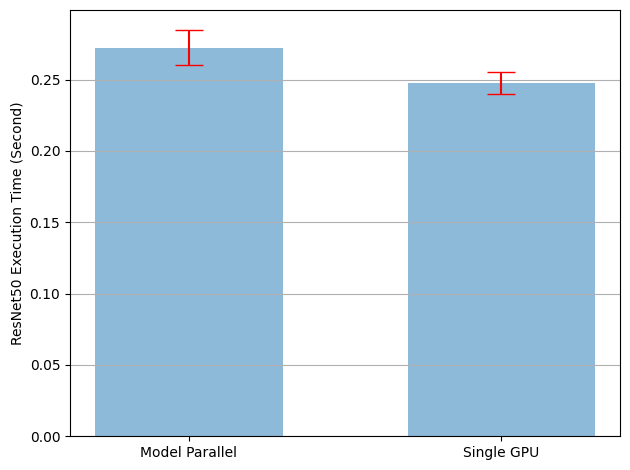

In [66]:
plot(
    [mp_mean, rn_mean],
    [mp_std, rn_std],
    ['Model Parallel', 'Single GPU'],
    'model_parallel.png'
)
# 对比可以看出模型并行的速度比单卡慢了很多，主要是因为数据需要在两张GPU之间传输

那么对于这种情况有没有办法进行改进呢？答案是肯定的，借鉴之前的流水线CPU，我们可以将每个batch的image进一步划分为一个个的splits，这样当一个split到达第二个子网络的时候，下面的split可以被送入第一个子网络，这样两个连续的splits就可以在两个GPU上同时运行

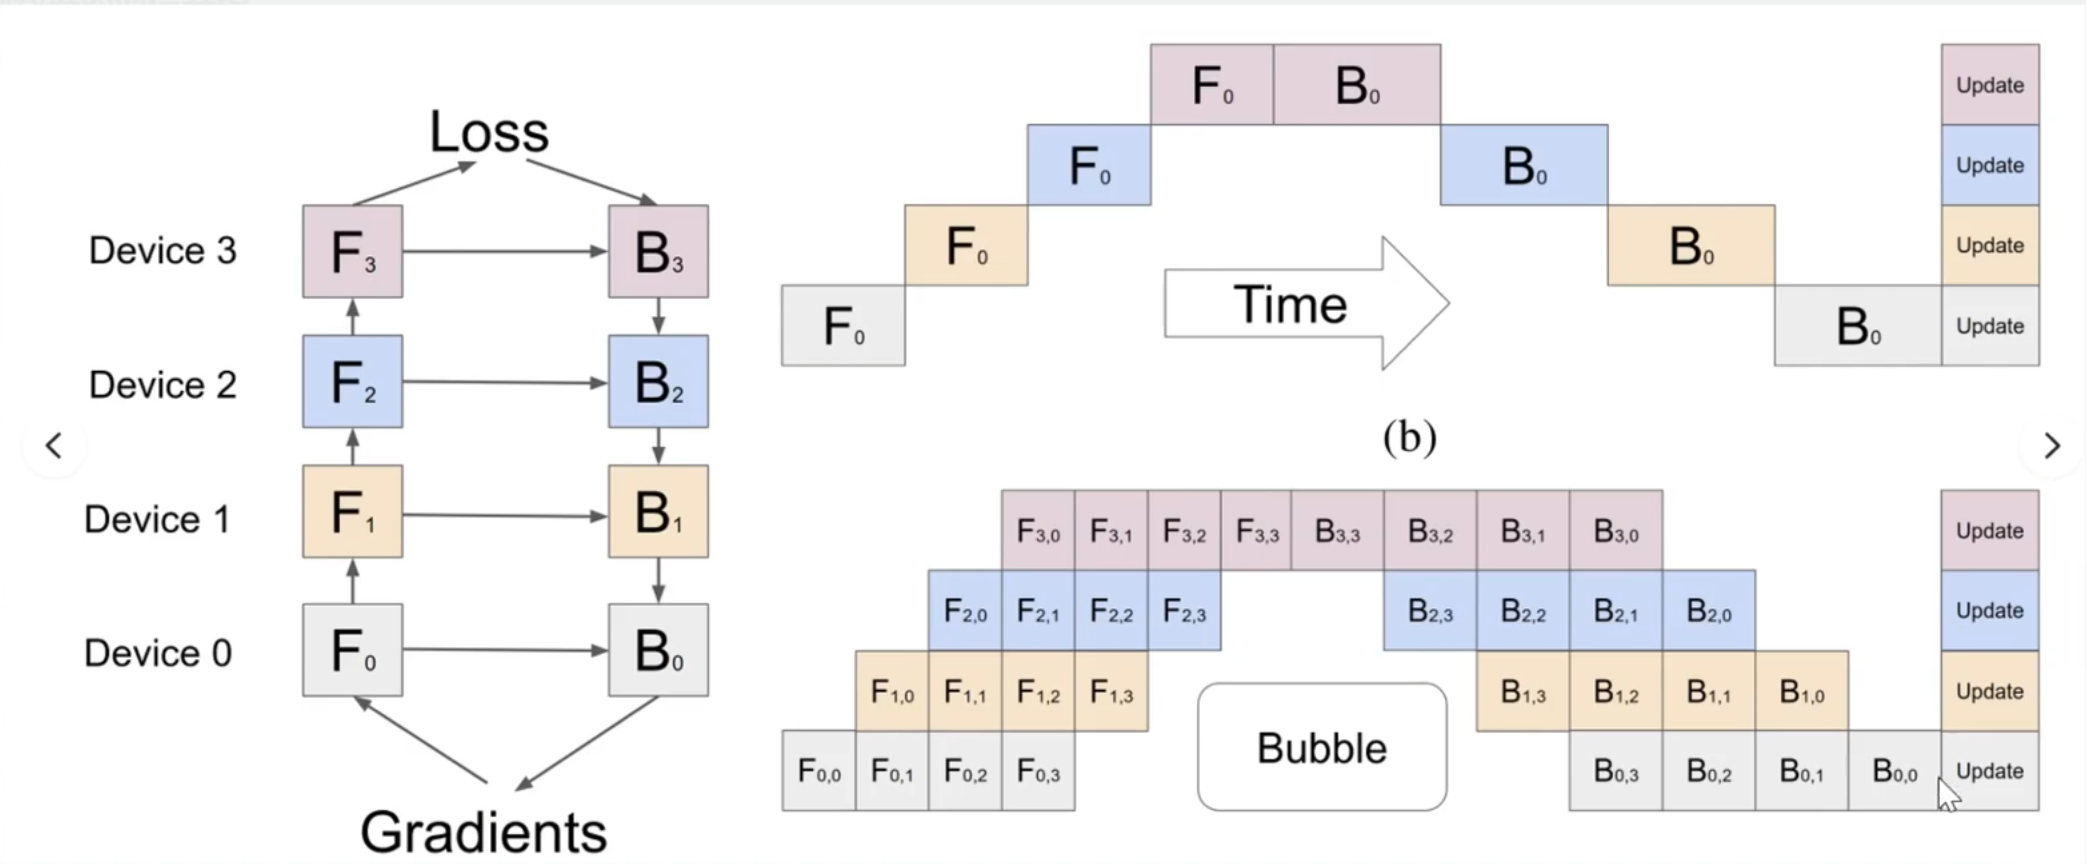

torch官网也给出了这样一个`torch.split`函数：`torch.split(tensor,split_size_or_sections,dim=0)`：

+ tensor (Tensor) – tensor to split.
+ split_size_or_sections (int) or (list(int)) – size of a single chunk or list of sizes for each chunk
+ dim (int) – dimension along which to split the tensor.

如果 split_size_or_sections 是一个整数类型，那么张量将被分割成同等大小的块。如果张量沿着给定的维度 dim 的大小不能被 split_size 整除，那么最后一个块会更小

如果 split_size_or_sections 是一个列表，那么张量将被分割成 len(split_size_or_sections) 个小块，其大小与 split_size_or_sections 相同

In [67]:
a = torch.arange(10).reshape(5, 2)
print(a)
print(torch.split(a, 2, dim=0))
print(torch.split(a, [1,4]))

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
(tensor([[0, 1],
        [2, 3]]), tensor([[4, 5],
        [6, 7]]), tensor([[8, 9]]))
(tensor([[0, 1]]), tensor([[2, 3],
        [4, 5],
        [6, 7],
        [8, 9]]))


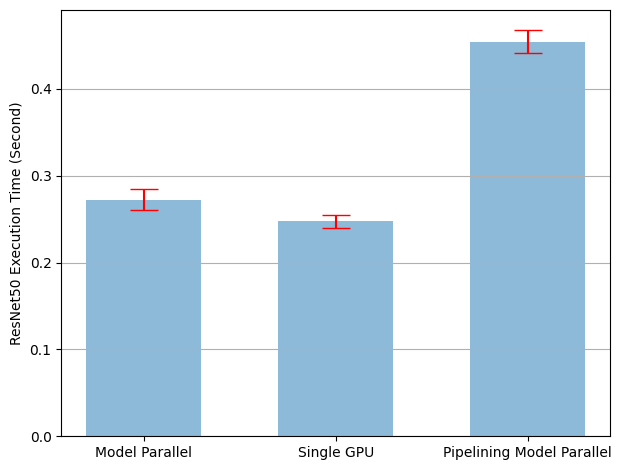

In [68]:
# 借助split操作，我们可以改进我们的forward函数

class PipelineParallelResNet50(ModelParallelResNet50):
    def __init__(self, split_size=20, *arg, **kwargs):
        super().__init__(*arg, **kwargs)
        self.split_size = split_size
    
    # override
    def forward(self, x):
        splits = iter(x.split(self.split_size, dim=0))
        s_next = next(splits)
        s_prev = self.seq1(s_next).to('cuda:1')
        ret = []

        for s_next in splits:
            # A. s_prev runs on cuda:1
            s_prev = self.seq2(s_prev)
            ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

            # B. s_next runs on cuda:0, which can run concurrently with A
            s_prev = self.seq1(s_next).to('cuda:1')

        s_prev = self.seq2(s_prev)
        ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

        return torch.cat(ret)
    
    
setup = "model = PipelineParallelResNet50()"
pp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals()
)                
pp_mean, pp_std = np.mean(pp_run_times), np.std(pp_run_times)

plot([mp_mean, rn_mean, pp_mean],
     [mp_std, rn_std, pp_std],
     ['Model Parallel', 'Single GPU', 'Pipelining Model Parallel'],
     'mp_vs_rn_vs_pp.png')

In [ ]:
# 由于我们给训练引入了一个新的参数 split_size 因此我们需要确定最优的 split_size 从而实现最优运行时间，
# 下面可以遍历每一个 split_size 并绘制图形以确定最优参数
# 由于a100过于 **强大** 导致目前在单卡上吊打流水线，因为一个 ResNet50 还不够它塞牙缝

means = []
stds = []
split_sizes = [1, 3, 5, 8, 10, 12, 20, 40, 60]

for split_size in split_sizes:
    setup = "model = PipelineParallelResNet50(split_size=%d)" % split_size
    print(setup)
    pp_run_times = timeit.repeat(
        stmt, setup, number=1, repeat=num_repeat, globals=globals())
    means.append(np.mean(pp_run_times))
    stds.append(np.std(pp_run_times))

fig, ax = plt.subplots()
ax.plot(split_sizes, means)
ax.errorbar(split_sizes, means, yerr=stds, ecolor='red', fmt='ro')
ax.set_ylabel('ResNet50 Execution Time (Second)')
ax.set_xlabel('Pipeline Split Size')
ax.set_xticks(split_sizes)
ax.yaxis.grid(True)
plt.tight_layout()
plt.savefig("split_size_tradeoff.png")
plt.close(fig)

model = PipelineParallelResNet50(split_size=1)
model = PipelineParallelResNet50(split_size=3)
model = PipelineParallelResNet50(split_size=5)
model = PipelineParallelResNet50(split_size=8)
model = PipelineParallelResNet50(split_size=10)
model = PipelineParallelResNet50(split_size=12)
model = PipelineParallelResNet50(split_size=20)
model = PipelineParallelResNet50(split_size=40)
model = PipelineParallelResNet50(split_size=60)


虽然流水线模型已经将模型分布在多张卡上以减小显存的占用，但是由于是用来多个micro-batch，会使得内存中需要保存的中间变量随split的大小而变化，micro-batch越多需要缓存的中间变量也就越多，反而会导致显存的占用增加，如何解决？GPipe提出了重计算的概念解决这个问题

重计算的思想就是对于模型并行的每一层，不保留中间变量，只保留来自上一层的输入，反向计算时再通过重新前向计算获取梯度，这样就降低了每个设备上内存占用峰值，**需要注意的是重计算并非不需要中间变量，而是在求导过程中可以实时计算出之前舍弃的中间结果，即以时间换取空间**

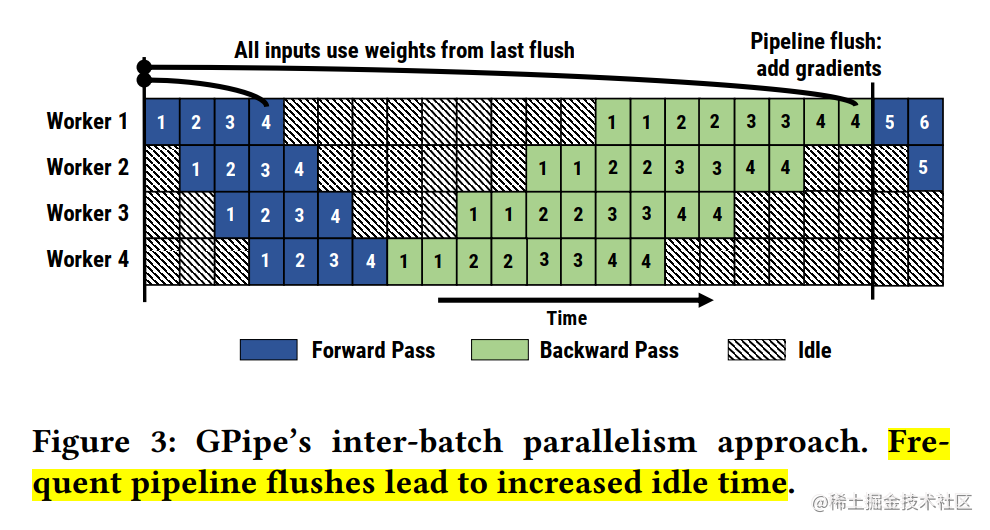

为什么图中会有两个1？这是因为重计算的原因，需要重新计算一次前向的结果

但是GPipe也还是会有问题，当流水线过长时，反向传播的过程可能会变得很长，因此后续又提出了1F1B的方法：

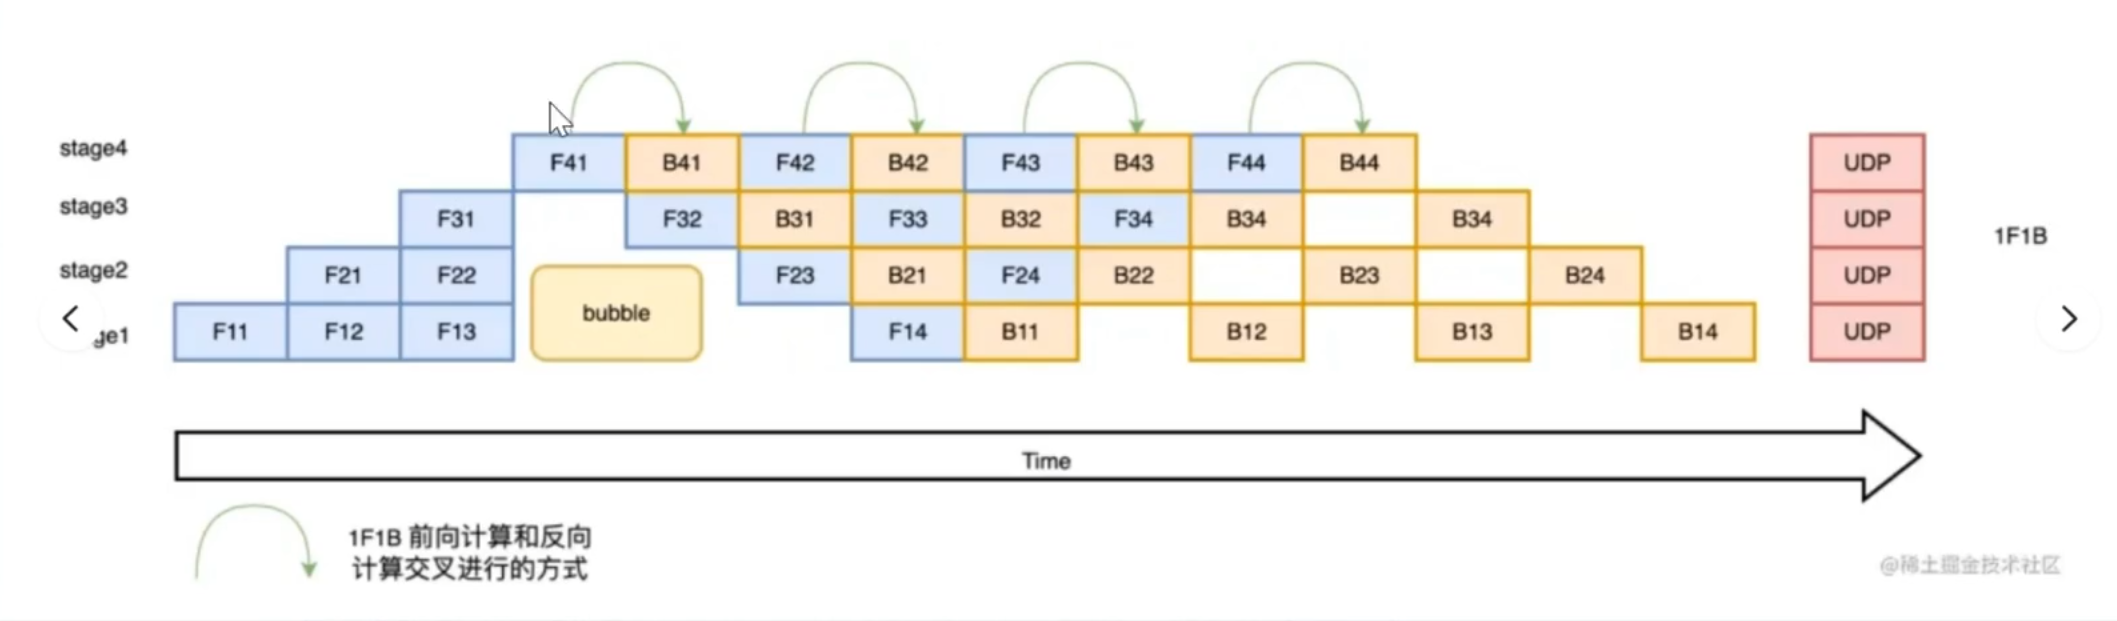

在1F1B的计算过程中，前向计算和反向计算交叉进行，可以及时释放不必要的中间变量，例如在图中的 F42 计算之前 F41的反向 B41 已经计算结束，即可以释放 F41 计算过程中产生的中间变量，从而 F42 可以复用 F41 的中间变量的显存，1F1B的方式相比于F-then-B的方式可以节省很多显存，但是这样并没有降低空泡率，这是因为流水线异步性的问题，必须等待，每一个work都更新完了本次batch的梯度之后，才能继续进行5、6、7、8的计算

+ 非交错式调度的1F1B，即PipeDream：

    PipeDream 的工作流程如下：

    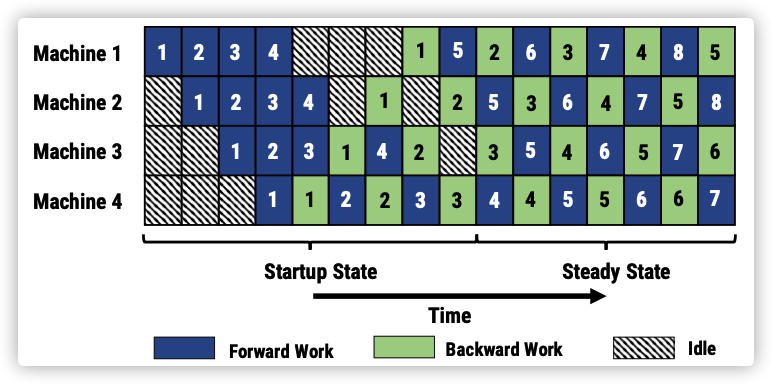

    可以看到 PipeDream 分为 Startup 阶段和 Steady 阶段，在 Steady 阶段每一个 worker 会交替进行前向和后向传播，PipeDream 会忽略 Start 阶段，通过 warm up 实现，这样在 steady 阶段，会有两种参数不一致性：
    + 考虑在同一个 stage 中，一个 micro-batch 在前向传播和后向传播时使用的是不同的参数版本
    + 考虑不同的stage，同一个 micro-batch 在前向传播和后向传播时也会使用不同的参数版本

    PipeDream 使用两种技巧来解决上述的两个问题
    + weight stashing：为权重维护多个版本，每个active minibatch 都有一个版本号，每个stage都用最新版本的权重进行前向计算，处理输入的minibatch，计算前向传播之后，会将这份参数保存下来用于后续的后向传播，即保证在一同stage，同一个mini-batch使用同一个版本的参数进行计算，流程图如下：

    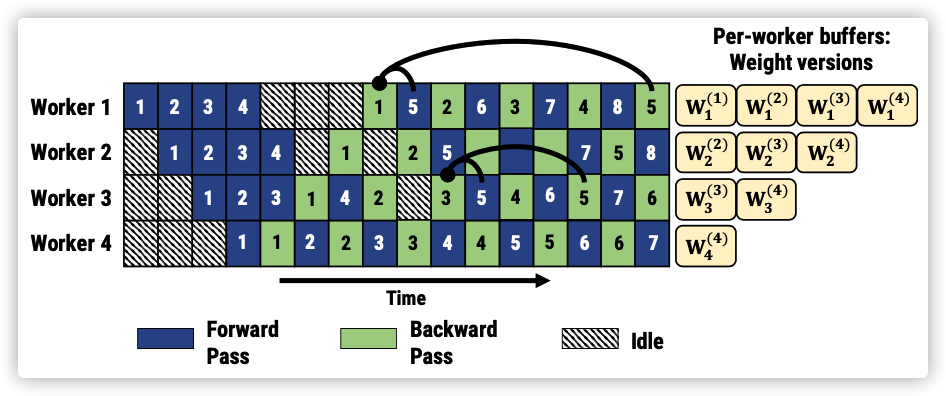

    因此需要缓存的权重和流水线的深度有关系

    + vertical sync：每个 mini-batch 进入 pipeline 时都使用输入 stage 最新版本的参数，并且参数的版本号会伴随该 mini-batch 数据整个生命周期，这样就可以保证在各阶段使用都是同一个版本的参数，从而实现 stage 间的参数一致性

    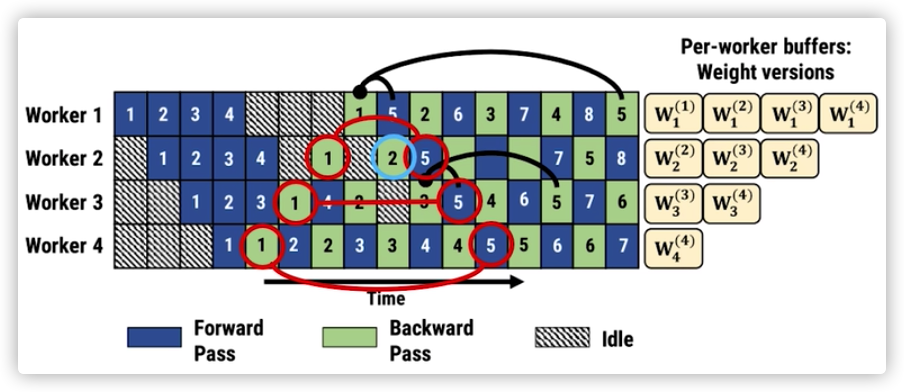

    同样的每个 stage 都需要维护之前版本的参数，同样和流水线的深度有关，但是，这样同步会导致很多计算浪费无用。比如5更新时用的1的权重，但2/3/4后向传播的权重都白白计算了，所以默认不使用Vertical Sync。这样虽然每层不完全一致，但是由于weight stashing的存在，所有的参数都是有效的

    PipeDream还有两个扩展版本，PipeDream-flush和PipeDream-2BW

+ 交错式调度的1F1B，即Megatron-LM：

    传统流水线并行通常会在一个设备上放置几个连续的模型层，可以认为在一个 mini-batch 的生命周期中，不会经过同一个 worker 两次，这样的问题是，如果使用同步技术，那么 GPU 的 IDLE 时间会和 GPipe 一样，但 Megatron 这篇论文采用虚拟流水线（virtual pipeline），进行交错式1F1B并行。在设备数量不变的情况下，分出更多的流水线阶段（pipeline stage），以更多的通信量，换取流水线Bubble比率降低

    例如，之前如果每个设备有 4 层（即设备 1 有 1 – 4 层，设备 2 有 5 – 8 层，依此类推），现在我们可以让每个设备对两个模型块执行计算（每个模型块有 2 层） ，即设备 1 有第 1、2、9、10 层； 设备 2 有第 3、4、11、12 层，依此类推。 通过这种方案，流水线中的每个设备都被分配多个流水线阶段（与以前相比，每个流水线阶段的计算量更少），**核心思想就是用通信代价换取利用率**

    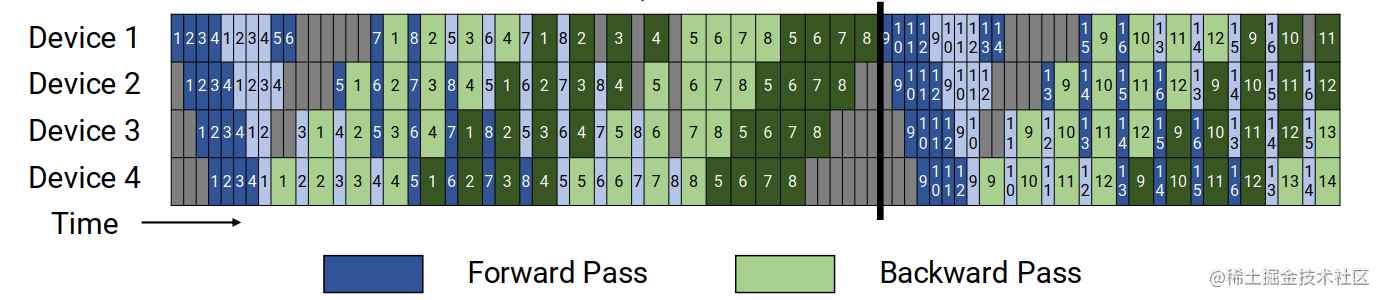

